In [3]:
!pip install gql requests pandas numpy --quiet


In [4]:
import pandas as pd
import numpy as np
import requests
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport
from datetime import datetime


In [ ]:
wallet_path = "/content/Wallet id - Sheet1.csv"
wallet_df = pd.read_csv(wallet_path)
wallet_df.columns
wallets = wallet_df['wallet_id'].dropna().unique().tolist()
wallets[:5]  # preview

['0x0039f22efb07a647557c7c5d17854cfd6d489ef3',
 '0x06b51c6882b27cb05e712185531c1f74996dd988',
 '0x0795732aacc448030ef374374eaae57d2965c16c',
 '0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9',
 '0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae']

In [6]:
wallet_df.columns

Index(['wallet_id'], dtype='object')

In [7]:
import requests
import pandas as pd

# --- Your Covalent API Key ---
API_KEY = "cqt_rQBQXVTVVPhqxhkDhjyC4dwWXjgF"

# --- Load wallets ---
wallet_df = pd.read_csv("/content/Wallet id - Sheet1.csv")
wallets = wallet_df['wallet_id'].dropna().str.lower().unique().tolist()

# --- Covalent API endpoint ---
CHAIN_ID = 1  # Ethereum Mainnet

def fetch_wallet_covalent(wallet):
    url = f"https://api.covalenthq.com/v1/{CHAIN_ID}/address/{wallet}/transactions_v2/"
    params = {"key": API_KEY, "page-size": 100}
    r = requests.get(url, params=params)
    r.raise_for_status()
    return r.json()

def features_from_covalent(data, wallet):
    # We'll try to count borrow, repay, liquidation from transaction logs or decode method calls if available
    # For simplicity, let's just count txs and value as example

    txs = data.get('data', {}).get('items', [])

    total_borrow = 0
    total_repay = 0
    num_liquidations = 0

    # Covalent response includes decoded calls, so you can scan method names
    for tx in txs:
        # Check for method names in decoded calls (if available)
        decoded = tx.get('decoded')
        if not decoded:
            continue
        method = decoded.get('name', '').lower()
        if 'borrow' in method:
            total_borrow += float(tx.get('value_quote', 0))
        elif 'repay' in method:
            total_repay += float(tx.get('value_quote', 0))
        elif 'liquidation' in method or 'liquidate' in method:
            num_liquidations += 1

    ratio = total_borrow / total_repay if total_repay else 1.5

    return {
        "wallet_id": wallet,
        "total_borrow": total_borrow,
        "total_repay": total_repay,
        "borrow_repay_ratio": ratio,
        "num_liquidations": num_liquidations,
        "num_borrows": sum('borrow' in (tx.get('decoded', {}).get('name', '').lower() or '') for tx in txs),
        "num_repays": sum('repay' in (tx.get('decoded', {}).get('name', '').lower() or '') for tx in txs),
    }

# --- Iterate safely ---
rows = []
for i, w in enumerate(wallets, 1):
    try:
        data = fetch_wallet_covalent(w)
        rows.append(features_from_covalent(data, w))
    except Exception as e:
        print(f"{i}/{len(wallets)} {w[:8]}… error: {e}")
        rows.append({
            "wallet_id": w,
            "total_borrow": 0,
            "total_repay": 0,
            "borrow_repay_ratio": 1.5,
            "num_liquidations": 0,
            "num_borrows": 0,
            "num_repays": 0,
        })

df_features = pd.DataFrame(rows)
print(df_features.head())


                                    wallet_id  total_borrow  total_repay  \
0  0x0039f22efb07a647557c7c5d17854cfd6d489ef3             0            0   
1  0x06b51c6882b27cb05e712185531c1f74996dd988             0            0   
2  0x0795732aacc448030ef374374eaae57d2965c16c             0            0   
3  0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9             0            0   
4  0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae             0            0   

   borrow_repay_ratio  num_liquidations  num_borrows  num_repays  
0                 1.5                 0            0           0  
1                 1.5                 0            0           0  
2                 1.5                 0            0           0  
3                 1.5                 0            0           0  
4                 1.5                 0            0           0  


In [8]:
import requests
import pandas as pd

# --- Your Covalent API Key ---
API_KEY = "cqt_rQBQXVTVVPhqxhkDhjyC4dwWXjgF"

# --- Load wallets ---
wallet_df = pd.read_csv("/content/Wallet id - Sheet1.csv")
wallets = wallet_df['wallet_id'].dropna().str.lower().unique().tolist()

# --- Covalent API endpoint ---
CHAIN_ID = 1  # Ethereum Mainnet

def fetch_wallet_covalent(wallet):
    url = f"https://api.covalenthq.com/v1/{CHAIN_ID}/address/{wallet}/transactions_v2/"
    params = {"key": API_KEY, "page-size": 100}
    r = requests.get(url, params=params)
    r.raise_for_status()
    return r.json()
def features_from_covalent(data, wallet):
    txs = data.get('data', {}).get('items', [])

    total_borrow = 0
    total_repay = 0
    num_liquidations = 0
    num_borrows = 0
    num_repays = 0

    print(f"--- Wallet: {wallet} ---")
    print("Detected event names:")

    for tx in txs:
        log_events = tx.get('log_events') or []  # safely handle None
        for log in log_events:
            decoded = log.get('decoded')
            if not decoded:
                continue
            event_name = decoded.get('name', '').lower()
            print(f"  {event_name}")

            decimals = log.get('sender_contract_decimals', 18)  # default to 18 if missing

            params = decoded.get('params') or []  # safely handle None
            if 'borrow' in event_name or event_name == 'mint':
                num_borrows += 1
                for param in params:
                    if param.get('name') == 'value':
                        amount = int(param.get('value', '0'))
                        total_borrow += amount / (10 ** decimals)
            elif 'repay' in event_name or event_name == 'redeem':
                num_repays += 1
                for param in params:
                    if param.get('name') == 'value':
                        amount = int(param.get('value', '0'))
                        total_repay += amount / (10 ** decimals)
            elif 'liquidate' in event_name or 'liquidation' in event_name:
                num_liquidations += 1

    ratio = total_borrow / total_repay if total_repay else 1.5

    return {
        "wallet_id": wallet,
        "total_borrow": total_borrow,
        "total_repay": total_repay,
        "borrow_repay_ratio": ratio,
        "num_liquidations": num_liquidations,
        "num_borrows": num_borrows,
        "num_repays": num_repays,
    }



# --- Iterate safely ---
rows = []
for i, w in enumerate(wallets, 1):
    try:
        data = fetch_wallet_covalent(w)
        rows.append(features_from_covalent(data, w))
    except Exception as e:
        print(f"{i}/{len(wallets)} {w[:8]}… error: {e}")
        rows.append({
            "wallet_id": w,
            "total_borrow": 0,
            "total_repay": 0,
            "borrow_repay_ratio": 1.5,
            "num_liquidations": 0,
            "num_borrows": 0,
            "num_repays": 0,
        })

df_features = pd.DataFrame(rows)
print(df_features.head())


Streaming output truncated to the last 5000 lines.
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersingle
  transfersing

In [9]:
data = fetch_wallet_covalent(wallets[0])
txs = data.get('data', {}).get('items', [])
if txs:
    print("Example tx:")
    print(txs[0])  # Look at all keys and values
else:
    print("No transactions found")


Example tx:
{'block_signed_at': '2025-06-16T21:15:11Z', 'block_height': 22719696, 'block_hash': '0xff57a0c234e73c4897632e198caa0074e84d16080e0f99731a3da891faebb42b', 'tx_hash': '0x98703fb4a7c6804d82e98f009ecc0e089abd53de94696088fb9675dde740c570', 'tx_offset': 108, 'successful': True, 'miner_address': '0x95222290dd7278aa3ddd389cc1e1d165cc4bafe5', 'from_address': '0xc6b602de080fc9ac9d96a431b2d749d38e77cbbc', 'from_address_label': None, 'to_address': '0x13173761e24c3708495b1dd314920f67f97011d0', 'to_address_label': None, 'value': '0', 'value_quote': 0.0, 'pretty_value_quote': '$0.00', 'gas_metadata': {'contract_decimals': 18, 'contract_name': 'Ether', 'contract_ticker_symbol': 'ETH', 'contract_address': '0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee', 'supports_erc': None, 'logo_url': 'https://www.datocms-assets.com/86369/1669619533-ethereum.png'}, 'gas_offered': 84929, 'gas_spent': 55815, 'gas_price': 4200000000, 'fees_paid': '234423000000000', 'gas_quote': 0.5993072070029296, 'pretty_gas_q

In [10]:
import pandas as pd

df = pd.DataFrame(rows)

# Fill any remaining NaNs or infinities
df.replace([float('inf'), -float('inf')], 0, inplace=True)
df.fillna(0, inplace=True)

# Convert appropriate columns to numeric if needed
numeric_cols = df.columns.drop('wallet_id')
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

df.head()


,wallet_id,total_borrow,total_repay,borrow_repay_ratio,num_liquidations,num_borrows,num_repays
0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,0.0,0,1.5,0,0,0
1,0x06b51c6882b27cb05e712185531c1f74996dd988,0.0,0,1.5,0,1,0
2,0x0795732aacc448030ef374374eaae57d2965c16c,0.0,0,1.5,0,1,0
3,0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9,0.0,0,1.5,0,4,0
4,0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae,0.0,0,1.5,0,1,0


In [11]:
def risk_category(score):
    if score >= 5:
        return 'High'
    elif score >= 3:
        return 'Medium'
    else:
        return 'Low'
def score_wallet(row):
    score = 0

    # High borrow/repay ratio could indicate financial stress
    if row['borrow_repay_ratio'] > 1.5:
        score += 2
    elif row['borrow_repay_ratio'] > 1.2:
        score += 1

    # Liquidations are penalized
    score += row['num_liquidations'] * 2

    # Borrowing without repaying
    if row['num_borrows'] > 0 and row['num_repays'] == 0:
        score += 1

    return score


In [12]:
print(df.columns.tolist())


['wallet_id', 'total_borrow', 'total_repay', 'borrow_repay_ratio', 'num_liquidations', 'num_borrows', 'num_repays']


In [13]:
df['risk_score'] = df.apply(score_wallet, axis=1)
df['risk_level'] = df['risk_score'].apply(risk_category)

# View results
df[['wallet_id', 'risk_score', 'risk_level']].head()


,wallet_id,risk_score,risk_level
0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,1,Low
1,0x06b51c6882b27cb05e712185531c1f74996dd988,2,Low
2,0x0795732aacc448030ef374374eaae57d2965c16c,2,Low
3,0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9,2,Low
4,0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae,2,Low


In [14]:
df.to_csv("wallet_risk_scores.csv", index=False)


In [26]:
wallet_risk_scores_1=pd.read_csv('/content/wallet_risk_scores.csv')

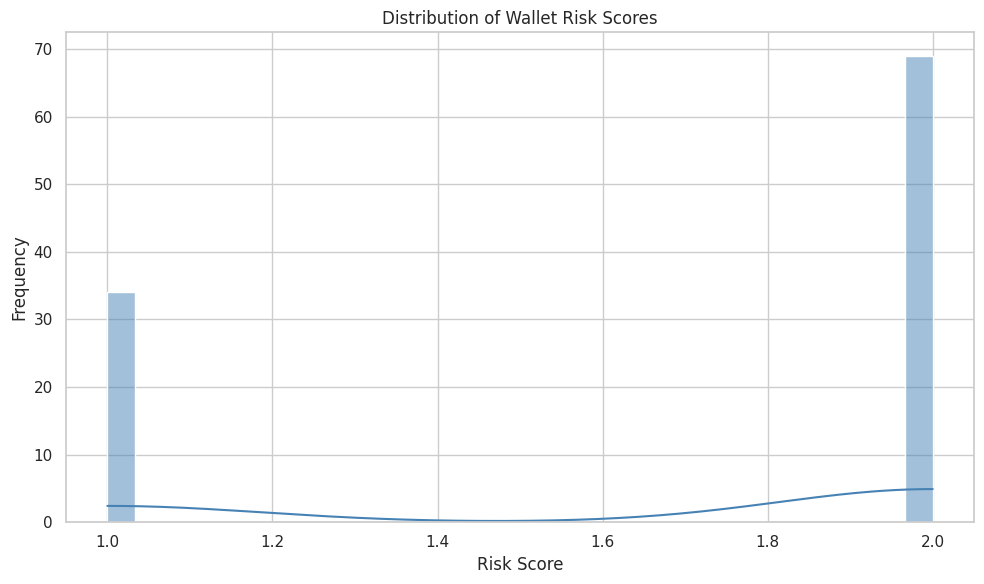

/tmp/ipython-input-27-3539622677.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='risk_level', order=sorted(df['risk_level'].unique()), palette="Set2")


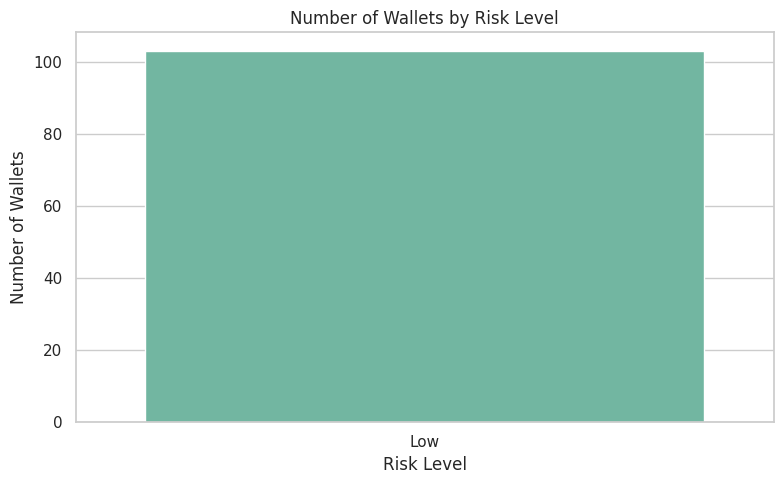

/tmp/ipython-input-27-3539622677.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='risk_level', y='risk_score', order=sorted(df['risk_level'].unique()), palette="coolwarm")


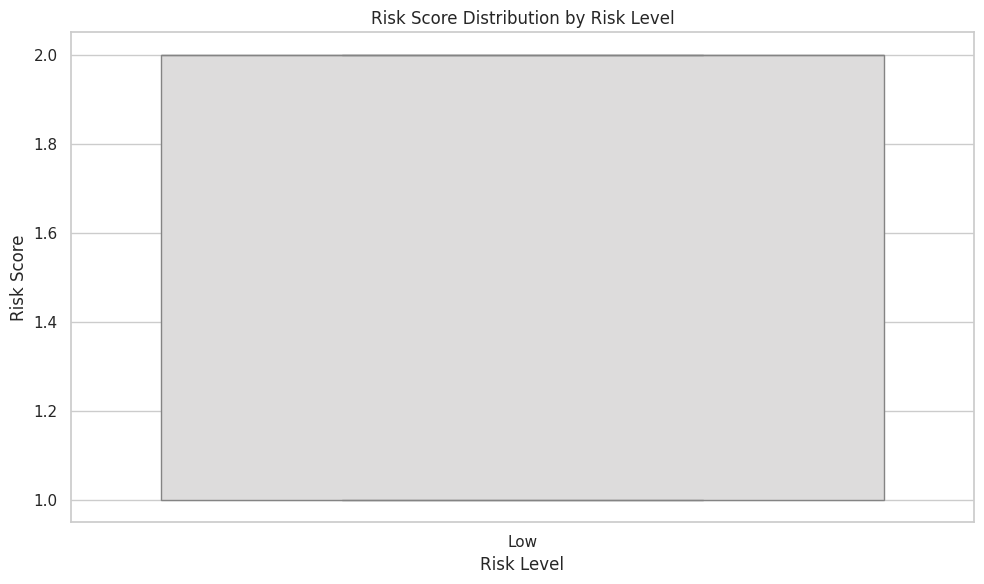

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV
df = wallet_risk_scores_1

# Set plot style
sns.set(style="whitegrid")

# --- 1. Histogram of Risk Scores ---
plt.figure(figsize=(10, 6))
sns.histplot(df['risk_score'], bins=30, kde=True, color='steelblue')
plt.title("Distribution of Wallet Risk Scores")
plt.xlabel("Risk Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# --- 2. Count of Wallets per Risk Level ---
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='risk_level', order=sorted(df['risk_level'].unique()), palette="Set2")
plt.title("Number of Wallets by Risk Level")
plt.xlabel("Risk Level")
plt.ylabel("Number of Wallets")
plt.tight_layout()
plt.show()

# --- 3. Boxplot of Risk Score by Risk Level ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='risk_level', y='risk_score', order=sorted(df['risk_level'].unique()), palette="coolwarm")
plt.title("Risk Score Distribution by Risk Level")
plt.xlabel("Risk Level")
plt.ylabel("Risk Score")
plt.tight_layout()
plt.show()


**Approach 2 with Normalization**

In [18]:
# --- 1. Setup and Imports ---
import requests
import pandas as pd
import time

# Covalent API Key and Base URL
API_KEY = "cqt_rQBQXVTVVPhqxhkDhjyC4dwWXjgF"  # Replace with your actual key
CHAIN_ID = 1  # Ethereum Mainnet
BASE_URL = f"https://api.covalenthq.com/v1/{CHAIN_ID}/address"

# --- 2. Load Wallets ---
wallet_df = pd.read_csv("Wallet id - Sheet1.csv")
wallets = wallet_df['wallet_id'].dropna().str.lower().unique().tolist()

# --- 3. Fetch Transactions ---
def fetch_wallet_transactions(wallet):
    url = f"{BASE_URL}/{wallet}/transactions_v3/"
    params = {"key": API_KEY, "page-size": 100}
    response = requests.get(url, params=params)
    response.raise_for_status()
    return response.json()

# --- 4. Feature Engineering from logs ---
def extract_features(data, wallet):
    txs = data.get('data', {}).get('items', [])
    total_borrow = 0
    total_repay = 0
    num_borrows = 0
    num_repays = 0
    num_liquidations = 0

    for tx in txs:
        log_events = tx.get('log_events') or []
        for log in log_events:
            decoded = log.get('decoded')
            if not decoded:
                continue

            event_name = decoded.get('name', '').lower()
            params = decoded.get('params') or []
            decimals = log.get('sender_contract_decimals', 18)

            if 'borrow' in event_name or event_name == 'mint':
                num_borrows += 1
                for param in params:
                    if param.get('name') == 'value':
                        val = int(param.get('value', 0))
                        total_borrow += val / (10 ** decimals)

            elif 'repay' in event_name or event_name == 'redeem':
                num_repays += 1
                for param in params:
                    if param.get('name') == 'value':
                        val = int(param.get('value', 0))
                        total_repay += val / (10 ** decimals)

            elif 'liquidate' in event_name or 'liquidation' in event_name:
                num_liquidations += 1

    return {
        "wallet_id": wallet,
        "total_borrow": total_borrow,
        "total_repay": total_repay,
        "num_borrows": num_borrows,
        "num_repays": num_repays,
        "num_liquidations": num_liquidations,
    }

# --- 5. Process All Wallets ---
rows = []
for i, wallet in enumerate(wallets, 1):
    try:
        print(f"{i}/{len(wallets)} Fetching {wallet[:8]}...")
        data = fetch_wallet_transactions(wallet)
        row = extract_features(data, wallet)
        rows.append(row)
    except Exception as e:
        print(f"{i}/{len(wallets)} {wallet[:8]}... error: {e}")
        rows.append({
            "wallet_id": wallet,
            "total_borrow": 0,
            "total_repay": 0,
            "num_borrows": 0,
            "num_repays": 0,
            "num_liquidations": 0,
        })
    time.sleep(0.3)

features_df = pd.DataFrame(rows)

# --- 6. Normalize and Score ---
import numpy as np

# Replace zeros to avoid division/log errors
features_df['total_borrow'] = features_df['total_borrow'].replace(0, 1e-6)
features_df['total_repay'] = features_df['total_repay'].replace(0, 1e-6)
features_df['num_liquidations'] = features_df['num_liquidations'].replace(0, 1e-6)

# Compute borrow/repay ratio
features_df['borrow_repay_ratio'] = features_df['total_borrow'] / features_df['total_repay']

# Log scaling for features to reduce skew and preserve relative differences
features_df['log_borrow'] = np.log1p(features_df['total_borrow'])
features_df['log_ratio'] = np.log1p(features_df['borrow_repay_ratio'])
features_df['log_liquidations'] = np.log1p(features_df['num_liquidations'])

# Min-max normalization on log-scaled features
def normalize(series):
    return (series - series.min()) / (series.max() - series.min() + 1e-6)

features_df['norm_borrow'] = normalize(features_df['log_borrow'])
features_df['norm_borrow_repay_ratio'] = normalize(features_df['log_ratio'])
features_df['norm_liquidations'] = normalize(features_df['log_liquidations'])

# Weighted scoring (adjust weights if needed)
features_df['score'] = (
    0.4 * features_df['norm_borrow'] +
    0.4 * features_df['norm_borrow_repay_ratio'] +
    0.2 * features_df['norm_liquidations']
) * 1000


# --- 7. Export Final Scores ---
final_df = features_df[['wallet_id', 'score']].copy()
final_df['score'] = final_df['score'].round().astype(int)
final_df.to_csv("wallet_risk_scores.csv", index=False)


1/103 Fetching 0x0039f2...
2/103 Fetching 0x06b51c...
3/103 Fetching 0x079573...
4/103 Fetching 0x0aaa79...
5/103 Fetching 0x0fe383...
6/103 Fetching 0x104ae6...
7/103 Fetching 0x111c72...
8/103 Fetching 0x124853...
9/103 Fetching 0x13b1c8...
10/103 Fetching 0x1656f1...
11/103 Fetching 0x1724e1...
12/103 Fetching 0x19df3e...
13/103 Fetching 0x1ab2cc...
14/103 Fetching 0x1c1b30...
15/103 Fetching 0x1e43da...
16/103 Fetching 0x22d751...
17/103 Fetching 0x24b346...
18/103 Fetching 0x26750f...
19/103 Fetching 0x27f72a...
20/103 Fetching 0x284465...
21/103 Fetching 0x2a2fde...
22/103 Fetching 0x330513...
23/103 Fetching 0x3361be...
24/103 Fetching 0x3867d2...
25/103 Fetching 0x3a44be...
26/103 Fetching 0x3e69ad...
27/103 Fetching 0x427f2a...
28/103 Fetching 0x4814be...
29/103 Fetching 0x4839e6...
30/103 Fetching 0x4c4d05...
31/103 Fetching 0x4d997c...
32/103 Fetching 0x4db0a7...
33/103 Fetching 0x4e6125...
34/103 Fetching 0x4e6e72...
35/103 Fetching 0x507b6c...
36/103 Fetching 0x54e196...
3

In [20]:
wallet_risk_scores=pd.read_csv('/content/wallet_risk_scores.csv')

In [23]:
wallet_risk_scores['score'].values

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0, 800,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])